In [308]:
import torch
from torch import (optim)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearSVM,
    HingeLoss,
    Trainer
)

# User-defined functions
from utils.preprocess import clusters

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [ ]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [310]:
X, y = clusters(SIZE, stds=[1.2, 1], labels=[-1, 1], dtype=DTYPE, generator=GENERATOR)

In [311]:
print("Generated X:", X[90:110], "\nGenerated y:", y[90:110], sep='\n')     # Viewing both +1 and -1
print("\nShape of X: ", X.shape, "\nShape of y: ", y.shape, sep='\n')

Generated X:
tensor([[-4.1183, -4.9092],
        [-4.3632, -3.6271],
        [-3.1912, -3.5099],
        [-1.8669, -3.2219],
        [-1.7270, -2.7500],
        [-3.6934, -2.6094],
        [-2.6859, -3.9119],
        [-5.4554, -4.8353],
        [-2.5142, -2.2417],
        [-2.6250, -3.0402],
        [ 4.3032,  3.4879],
        [ 4.1340,  2.6444],
        [ 3.3618,  4.9993],
        [ 3.6630,  3.7047],
        [ 3.0213,  2.1707],
        [ 1.9191,  2.2161],
        [ 3.5071,  3.0821],
        [ 3.4440,  2.2760],
        [ 2.5389,  2.9361],
        [ 1.6333,  3.3298]])

Generated y:
tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.])

Shape of X: 
torch.Size([200, 2])

Shape of y: 
torch.Size([200])


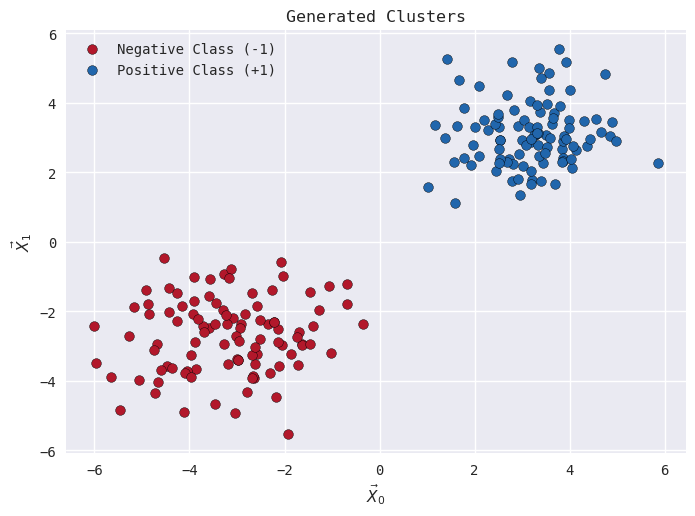

In [312]:
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='#b2182b', label='Negative Class (-1)', edgecolors='k')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='#2166ac', label='Positive Class (+1)', edgecolors='k')
plt.legend()
plt.xlabel('$\\vec{X}_0$')
plt.ylabel('$\\vec{X}_1$')
plt.title('Generated Clusters')
plt.show()

In [313]:
Data = TensorDataset(X, y)
Data[90:110]        # Slice of Dataset

(tensor([[-4.1183, -4.9092],
         [-4.3632, -3.6271],
         [-3.1912, -3.5099],
         [-1.8669, -3.2219],
         [-1.7270, -2.7500],
         [-3.6934, -2.6094],
         [-2.6859, -3.9119],
         [-5.4554, -4.8353],
         [-2.5142, -2.2417],
         [-2.6250, -3.0402],
         [ 4.3032,  3.4879],
         [ 4.1340,  2.6444],
         [ 3.3618,  4.9993],
         [ 3.6630,  3.7047],
         [ 3.0213,  2.1707],
         [ 1.9191,  2.2161],
         [ 3.5071,  3.0821],
         [ 3.4440,  2.2760],
         [ 2.5389,  2.9361],
         [ 1.6333,  3.3298]]),
 tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.]))

In [314]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)

In [315]:
model = LinearSVM(in_dims=2).to(DEVICE)

In [316]:
trainer = Trainer(
    model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(model.parameters(), lr=.1),
    criterion=HingeLoss(reduction='mean', is_soft=True, C=1.0),        # Soft Margin SVM
    device=DEVICE
)

In [317]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

Epoch 40/40 | Train Loss: 0.0000 | Val Loss: 0.0000: 100%|██████████| 40/40 [00:00<00:00, 121.89it/s]


In [318]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{1: 0.04368923120200634, 2: 0.009967272356152534, 3: 0.008086054772138595, 4: 0.006420764699578285, 5: 0.004675426706671715, 6: 0.0034490399062633514, 7: 0.0027024924755096437, 8: 0.0018278628587722779, 9: 0.0015706922858953476, 10: 0.0013135213404893876, 11: 0.0011312507092952728, 12: 0.00107363760471344, 13: 0.001016024500131607, 14: 0.0009584113955497742, 15: 0.0009007979184389115, 16: 0.0008431844413280487, 17: 0.0007855713367462159, 18: 0.0007279582321643829, 19: 0.0006703447550535202, 20: 0.0006127316504716873, 21: 0.0005551181733608246, 22: 0.0004975058138370514, 23: 0.00043989233672618865, 24: 0.0003822788596153259, 25: 0.0003246653825044632, 26: 0.00026705190539360045, 27: 0.00020943954586982727, 28: 0.00015182532370090486, 29: 9.42125916481018e-05, 30: 3.6599114537239075e-05, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0}

Validation Loss:
{1: 0.013412865810096264, 2: 0.003248453140258789, 3: 0.0010404027998447418, 4: 0.0

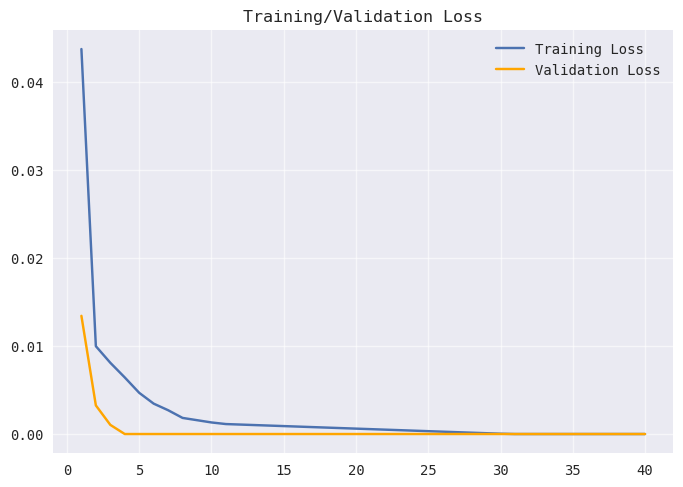

In [319]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [320]:
print(f"Predicted model Parameters:", "Weights: {}".format(model.linear.weight), "Bias: {}".format(model.linear.bias), sep="\n")

Predicted model Parameters:
Weights: Parameter containing:
tensor([[0.4756, 0.5999]], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([0.0527], device='cuda:0', requires_grad=True)


In [321]:
print(f"Shapes for Weight and Bias Tensors:", model.linear.weight.shape, model.linear.bias.shape, sep="\n")

Shapes for Weight and Bias Tensors:
torch.Size([1, 2])
torch.Size([1])


In [322]:
# Ensure model is in eval mode and on CPU for visualization
model.eval()
model.to('cpu')

# Extract weights and bias
w = model.linear.weight.detach().numpy()
b = model.linear.bias.detach().numpy()

In [323]:
# Convert X and y to NumPy arrays (for CPU processes)
Xnp = X.numpy()
ynp = y.numpy()

Xmin, Xmax = Xnp[:, 0].min() - 1, Xnp[:, 0].max() + 1
ymin, ymax = Xnp[:, 1].min() - 1, Xnp[:, 1].max() + 1
XX, yy = np.meshgrid(np.arange(Xmin, Xmax, 0.02), np.arange(ymin, ymax, 0.02))

print(f"Generated Grid of points:\n{(XX[:10], yy[:10])}")

Generated Grid of points:
(array([[-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       ...,
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637],
       [-7.01145363, -6.99145363, -6.97145363, ...,  6.80854637,
         6.82854637,  6.84854637]]), array([[-6.52662516, -6.52662516, -6.52662516, ..., -6.52662516,
        -6.52662516, -6.52662516],
       [-6.50662516, -6.50662516, -6.50662516, ..., -6.50662516,
        -6.50662516, -6.50662516],
       [-6.48662516, -6.48662516, -6.48662516, ..., -6.48662516,
        -6.48662516, -6.48662516],
       ...,
       [-6.38662516, -6.38662516, -6.38662516, 

In [324]:

# Predictionon the entire grid
Gp = np.c_[XX.ravel(), yy.ravel()]
G = torch.from_numpy(Gp).float()        # Grid Tensor

mean = X.mean(dim=0, keepdim=True)
std = X.std(dim=0, keepdim=True)
G = (G - mean) / (std + 1e-8)

# Inference
Z = model(G)

Z = Z.detach().numpy()
Z = Z.reshape(XX.shape)

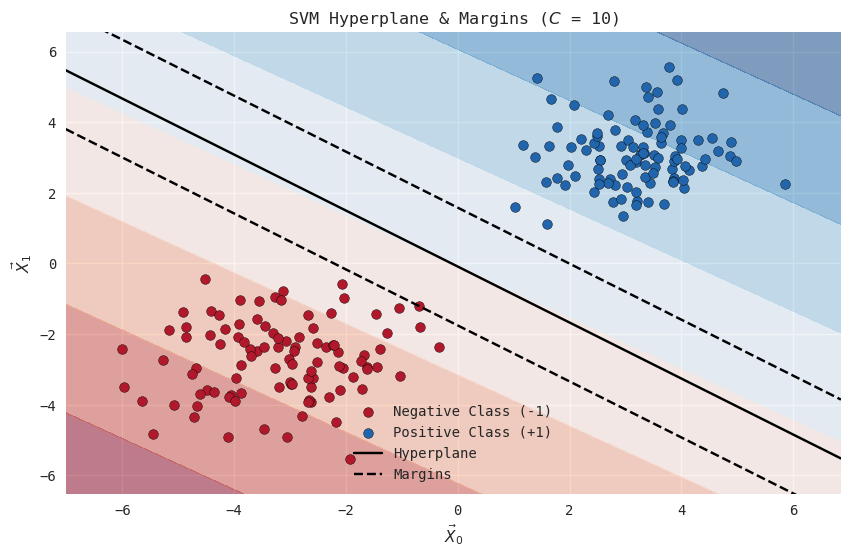

In [325]:

plt.figure(figsize=(10, 6))
# Decision Regions
plt.contourf(XX, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], c='#b2182b', label='Negative Class (-1)', edgecolors='k')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='#2166ac', label='Positive Class (+1)', edgecolors='k')

# Hyperplane
x_ = np.linspace(Xmin, Xmax, 100)
y_ = (-w[0, 0] * x_ - b) / w[0, 1]

plt.plot(x_, y_, 'k-', label='Hyperplane')

# Margins
margin = 1 / np.linalg.norm(w)

y_upper = (-w[0, 0] * x_ - b + 1) / w[0, 1]
y_lower = (-w[0, 0] * x_ - b - 1) / w[0, 1]

plt.plot(x_, y_upper, 'k--', label='Margins')
plt.plot(x_, y_lower, 'k--')

plt.xlim(XX.min(), XX.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('$\\vec{X}_0$')
plt.ylabel('$\\vec{X}_1$')
plt.title('SVM Hyperplane & Margins ($C$ = 10)')
plt.legend()
plt.show()